In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import enum
import random

In [2]:
plt.rcParams['figure.figsize'] = 20, 10
plt.rcParams['font.size'] = 16

# HH parameters

In [3]:
ParametersHH ={
    "E_K": -54., #mV
    "E_Na": 50., #mV
    "E_L": -54., #mV
    "C_m": 0.01, #µF/mm^2
    "gamma_K": 6., #pS
    "gamma_Na": 4 #pS
}

# Transition rates (taken from dyan abbott)

In [4]:
def alpha_n(V):
    return 0.01*(V+55) / (1-np.exp(-0.1*(V+55)))

def beta_n(V):
    return 0.125 * np.exp(-0.0125 * (V+65))

# sodium
def alpha_m(V):
    return 0.1*(V+40) / (1 - np.exp(-0.1*(V+40)))

def beta_m(V):
    return 4*np.exp(-0.0556*(V+65))

def alpha_h(V):
    return 0.07 * np.exp(-0.05*(V+65))

def beta_h(V):
    return 1 / (1 + np.exp(-0.1*(V+35)))

### some helpers for calculation


In [5]:
def tau_n(V):
    return 1/(alpha_n(V) + beta_n(V))
              
def n_inf(V):
    return alpha_n(V) * tau_n(V)

def dn_dt(t, n, V):
    #return (n_inf(V)-n)/tau_n(V)
    return -(alpha_n(V) + beta_n(V))*n + alpha_n(V)

def tau_h(V):
    return 1/(alpha_h(V) + beta_h(V))
              
def h_inf(V):
    return alpha_h(V) * tau_h(V)

def tau_m(V):
    return 1/(alpha_m(V) + beta_m(V))
              
def m_inf(V):
    return alpha_m(V) * tau_m(V)

def dm_dt(t, m, V):
    #return (n_inf(V)-n)/tau_n(V)
    return -(alpha_m(V) + beta_m(V))*m + alpha_m(V)

def dh_dt(t, h, V):
    #return (n_inf(V)-n)/tau_n(V)
    return -(alpha_h(V) + beta_h(V))*h + alpha_h(V)


# Utility

In [6]:
def invert_dict(d):
    return {v: k for k, v in d.items()}


# Simulation utility

In [7]:
def frac_open_channels(channels, *args):
    return np.sum([channel.is_open(*args) for channel in channels]) / len(channels)

def voltage_step_channels(channels, *args):
    for channel in channels:
        channel.voltage_step(*args)

In [8]:


# t_range = (t_init, t_step, t_end)
# V = (V_init, V_step)
def sim_voltage_steps(channel_class, n_channel, t_range, V, dt=0.05):
    t_init, t_step, t_end = t_range
    V_init, V_step = V

    
    T = np.arange(t_init, t_end, dt)
    
    channels = [channel_class(V_init, t_init) for _ in range(n_channel)]
    
    #print(channels)
    
    x_stoch = [frac_open_channels(channels, t_init)]

    for t in T[T<t_step]:
        x_stoch.append(frac_open_channels(channels, t))

    voltage_step_channels(channels, t_step, V_step)

    for t in T[T>=t_step]:
        x_stoch.append(frac_open_channels(channels, t))
        
    #print(x_stoch)


    return T, np.array(x_stoch)[0:-1]
    
    

In [9]:
def voltage_step_gating_variables(t_start, t_end, V_0, V_1, t_step):
    t = []
    n = []
    m = []
    h = []
    v = []

    sol = scipy.integrate.solve_ivp(
        lambda t, y: [dn_dt(t, y[0], V_0), dm_dt(t, y[1], V_0), dh_dt(t, y[2], V_0)],
        (t_start, t_step),
        [n_inf(V_0), m_inf(V_0), h_inf(V_0)],
        rtol=1e-12, atol=1e-12
    )
    
    t.append(sol.t)
    n.append(sol.y[0])
    m.append(sol.y[1])
    h.append(sol.y[2])
    v.append(np.full_like(sol.t, V_0))

    sol = scipy.integrate.solve_ivp(
        lambda t, y: [dn_dt(t, y[0], V_1), dm_dt(t, y[1], V_1), dh_dt(t, y[2], V_1)],
        (t_step, t_end),
        sol.y[:,-1],
        rtol=1e-12, atol=1e-12
    ) 
    
    
    t.append(sol.t)
    n.append(sol.y[0])
    m.append(sol.y[1])
    h.append(sol.y[2])
    v.append(np.full_like(sol.t, V_1))
    
    
    return {'t': np.concatenate(t), 
            'n': np.concatenate(n), 
            'm': np.concatenate(m), 
            'h': np.concatenate(h), 
            'V': np.concatenate(v)}


# Base classes
## Transition matrix base class

In [10]:
class TransitionMatrix:
    def __init__(self, transition_matrix):
        self._T = transition_matrix
        
    def state_sum(self, channel, V):
        return np.sum([f(V) for f in self._T[channel,:]])
    
    def state_cumsum(self, channel, V):
        return np.cumsum([f(V) for f in self._T[channel,:]])
    
    def state_normed_cumsum(self, channel, V):
        cumsum = np.cumsum([f(V) for f in self._T[channel,:]])
        return  cumsum / cumsum[-1]
    
    @staticmethod
    def lambda_matrix(N):
        T = []
        for i in range(N):
            row = []
            for j in range(N):
                row.append(lambda V: 0.)
            T.append(row)

        return np.array(T)

## Channel base class

In [11]:
class Channel:
    def __init__(self, V_0, t_0, transition_matrix, initial_state_probs, open_state):
        
        self._transition_matrix = transition_matrix
        
        self._open_state = open_state
        
        r_1 = random.random()
        
        self._V = V_0
        self._state = np.searchsorted(np.cumsum(initial_state_probs), r_1)
        self._next_t = self._duration(self._state, V_0) + t_0
        
        self._state_history = [(t_0, self._state)]
        
    def _duration(self, state, V):
        return -1 / self._transition_matrix.state_sum(state, V) * np.log(random.random())
    
    def _new_state(self, V):
        r = random.random()
        probs = self._transition_matrix.state_normed_cumsum(self._state, V)
        # print(probs, r, np.searchsorted(probs, r))
        return np.searchsorted(probs, r)
    
    def next_step(self):
        return self._next_t
    
    
    def is_open(self, t):
        # print("is_open")
        if t < self._next_t:
            #for i, (prev_t, prev_state) in enumerate(reversed(self._state_history)):
                # print(prev_t, prev_state)
            #    if t >= prev_t:
            #        return prev_state == self._open_state
            #if t >= self._state_history[0][0]:
            #    return self._state_history[1][1] == self._open_state
            #else:
            for (prev_t, prev_state) in reversed(self._state_history):
                if t >= prev_t:
                    return prev_state == self._open_state
            raise RuntimeError("t < t_0")
        else:
            while t > self._next_t:
                # print("is_open: while t > self._next_t, self._next_t = ", self._next_t)
                self._update_state()
            return self._state == self._open_state
        
    def voltage_step(self, t_step, V_new):
        while t_step > self._next_t:     
            self._update_state()
            
        # set last step end to t_step
        #self._state_history[-1] = (t_step, self._state)
        
        self._next_t = t_step
        #self._state = self._new_state(V_new)
        #self._state_history.append((self._next_t, self._state))
        
        
        self._next_t += self._duration(self._state, V_new)
        self._V = V_new
        
        
    
    def _update_state(self):
        self._state = self._new_state(self._V)
        self._state_history.append((self._next_t, self._state))
        
        self._next_t += self._duration(self._state, self._V)

# Potassium 

In [12]:
KState = {
    "1": 0,
    "2": 1,
    "3": 2,
    "4": 3,
    "5": 4
}

KStateRev = invert_dict(KState)

class KTransitionMatrix(TransitionMatrix):
    def __init__(self):
        
        T = TransitionMatrix.lambda_matrix(5)
        
        T[KState["1"], KState["2"]] = lambda V: 4*alpha_n(V)
        
        T[KState["2"], KState["1"]] = lambda V: beta_n(V)
        T[KState["2"], KState["3"]] = lambda V: 3*alpha_n(V)
        
        T[KState["3"], KState["2"]] = lambda V: 2*beta_n(V)
        T[KState["3"], KState["4"]] = lambda V: 2*alpha_n(V)
        
        T[KState["4"], KState["3"]] = lambda V: 3*beta_n(V)
        T[KState["4"], KState["5"]] = lambda V: alpha_n(V)
        
        T[KState["5"], KState["4"]] = lambda V: 4*beta_n(V)
        
        super().__init__(T)
        
class KChannel(Channel):
    def __init__(self, V_0, t_0, transition_matrix=KTransitionMatrix()):
        
        # for now, the only initial state is [1]
        initial_state_probs = np.array([
            1, 0,0,0,0
        ])
        
        super().__init__(V_0, t_0, transition_matrix, initial_state_probs, KState["5"] )

# Intermediate sodium model (dyan abbott chapter 5.7)

In [13]:

NaInterModelState = { 
    "1": 0,
    "2": 1,
    "3": 2,
    "4": 3,
    "5": 4
}

NaInterModelStateRev = invert_dict(NaInterModelState)

class NaInterModelTransitionMatrix(TransitionMatrix):
    def __init__(self):
        
        k_1 = 0.24
        k_2 = 0.4
        k_3 = 1.5
        
        T = TransitionMatrix.lambda_matrix(5)
        
        T[NaInterModelState["1"], NaInterModelState["2"]] = lambda V: 3*alpha_m(V)
        
        T[NaInterModelState["2"], NaInterModelState["1"]] = lambda V: beta_m(V)
        T[NaInterModelState["2"], NaInterModelState["3"]] = lambda V: 2*alpha_m(V)
        T[NaInterModelState["2"], NaInterModelState["5"]] = lambda V: k_1
        
        T[NaInterModelState["3"], NaInterModelState["2"]] = lambda V: 2*beta_m(V)
        T[NaInterModelState["3"], NaInterModelState["4"]] = lambda V: alpha_m(V)
        T[NaInterModelState["3"], NaInterModelState["5"]] = lambda V: k_2
        
        T[NaInterModelState["4"], NaInterModelState["3"]] = lambda V: 3*beta_m(V)
        T[NaInterModelState["4"], NaInterModelState["5"]] = lambda V: k_3
        
        T[NaInterModelState["5"], NaInterModelState["3"]] = lambda V: alpha_h(V)
        
        super().__init__(T)

class NaInterModelChannel(Channel):
    def __init__(self, V_0, t_0, transition_matrix=NaInterModelTransitionMatrix()):
        
        # for now, the only initial state is [1]
        initial_state_probs = np.array([
            1, 0,0,0,0
        ])
        
        super().__init__(V_0, t_0, transition_matrix, initial_state_probs, NaInterModelState["4"] )


# Membrane patch

In [14]:
class PatchChannel:
    def __init__(self, channel_class, n_channel, V_0, t_0):
        self._channels = [channel_class(V_0, t_0) for _ in range(n_channel)]
        
    def opening_prop(self, t):
        return frac_open_channels(self._channels, t)
    
    def open_channels(self, t):
        return np.sum([channel.is_open(t) for channel in self._channels]) 
    

class PatchNaChannel(PatchChannel):
    def __init__(self, channel_class, n_channel, V_0, t_0):
        super().__init__(channel_class, n_channel, V_0, t_0)

class PatchKChannel(PatchChannel):
    def __init__(self, channel_class, n_channel, V_0, t_0):
        super().__init__(channel_class, n_channel, V_0, t_0)

# Voltage clamps

In [22]:
solHH = voltage_step_gating_variables(0, 20, -100, 15, 5)

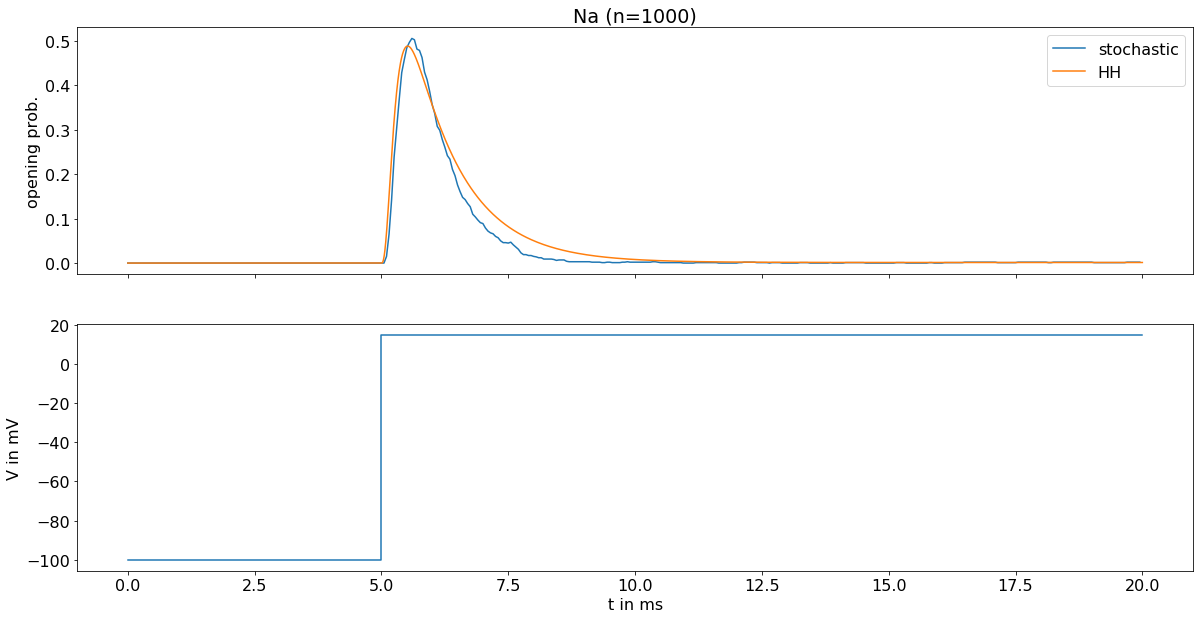

In [23]:
n = 1000
t, frac_open = sim_voltage_steps(NaInterModelChannel, n, (0, 5, 20), (-100, 10))

fig, axs = plt.subplots(nrows=2, sharex=True)

axs[0].title.set_text(f"Na (n={n})")
axs[0].plot(t, frac_open, label='stochastic')
axs[0].plot(solHH['t'], solHH['h']*solHH['m']**3, label='HH')

axs[0].set_ylabel('opening prob.')
axs[0].legend()

axs[1].plot(solHH['t'], solHH['V'])
axs[1].set_xlabel('t in ms')
axs[1].set_ylabel('V in mV')

plt.show()

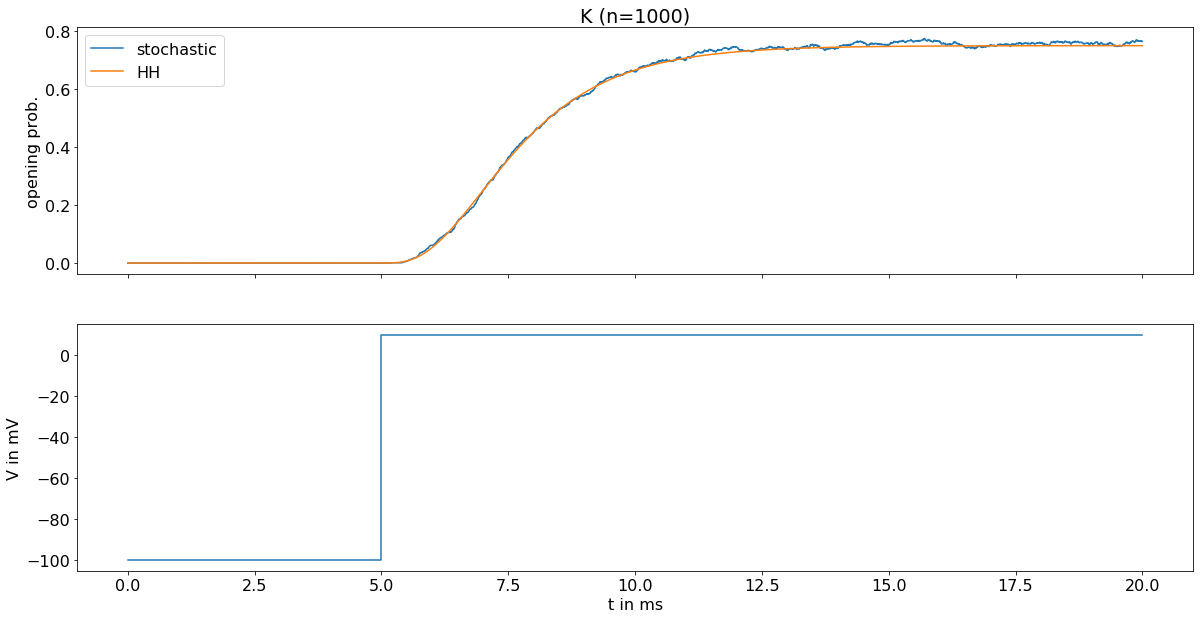

In [17]:
n = 1000
t, frac_open = sim_voltage_steps(KChannel, n, (0, 5, 20), (-100, 10), dt=0.005)

fig, axs = plt.subplots(nrows=2, sharex=True)

axs[0].title.set_text(f"K (n={n})")
axs[0].plot(t, frac_open, label='stochastic')
axs[0].plot(solHH['t'], solHH['n']**4, label='HH')

axs[0].set_ylabel('opening prob.')
axs[0].legend()

axs[1].plot(solHH['t'], solHH['V'])
axs[1].set_xlabel('t in ms')
axs[1].set_ylabel('V in mV')

plt.show()

# Stochastic Hodgin-Huxley

In [18]:
class ChannelCont:
    def __init__(self, V_0, transition_matrix, initial_state_probs, open_state):
        
        self._transition_matrix = transition_matrix
        
        self._open_state = open_state

        r_1 = random.random()
        self._state = np.searchsorted(np.cumsum(initial_state_probs), r_1)
           
        self._integrand = lambda V_t: self._transition_matrix.state_sum(self._state, V_t)
        self._integral = 0.
        self._last_integrand = self._integrand(V_0)
        self._log_r = np.log(random.random())
        
    def _new_state(self, V):
        r = random.random()
        probs = self._transition_matrix.state_normed_cumsum(self._state, V)
        return np.searchsorted(probs, r)
    
    def reset_and_new_state(self, V):
        self._state = self._new_state(V)
        
        self._integrand = lambda V_t: self._transition_matrix.state_sum(self._state, V_t)
        self._integral = 0.
        self._last_integrand = self._integrand(V)
        self._log_r = np.log(random.random())
        
    def reset(self, V):
        self._integral = 0.
        self._last_integrand = self._integrand(V)
        self._log_r = np.log(random.random())
        
    def step(self, dt, V):
        new_integrand = self._integrand(V)
        self._integral += dt * (self._last_integrand + self._integrand(V)) / 2
        
        self._last_integrand = new_integrand
        
        if self._integral + self._log_r > 0:
            #print("step!")
            self.reset_and_new_state(V)

            
    def is_open(self):
        return self._state == self._open_state
            
class KChannelCont(ChannelCont):
    def __init__(self, V_0, transition_matrix=KTransitionMatrix()):
        
        # for now, the only initial state is [1]
        initial_state_probs = np.array([
            1, 0,0,0,0
        ])
        
        super().__init__(V_0, transition_matrix, initial_state_probs, KState["5"] )
        
class NaInterModelChannelCont(ChannelCont):
    def __init__(self, V_0, transition_matrix=NaInterModelTransitionMatrix()):
        
        # for now, the only initial state is [1]
        initial_state_probs = np.array([
            1, 0,0,0,0
        ])
        
        super().__init__(V_0, transition_matrix, initial_state_probs, NaInterModelState["4"] )
        
def count_open_channels(channels):
    return np.sum([channel.is_open() for channel in channels])

In [19]:
dt = 0.001
dt_channel = 0.05

step_channel = int(dt_channel / dt)

T = np.arange(0, 80, dt)

V_0 = -60.

I_e = 0.3 #pA
Cs = 1 #pf

V = [V_0]

channel = KChannelCont(V_0)

n_K = 60
n_Na = 300

K_channels = [KChannelCont(V_0) for _ in range(n_K)]
Na_channels = [NaInterModelChannelCont(V_0) for _ in range(n_Na)]


for i, t in enumerate(T):
    #n_Na = self._open_Na_channels() / 1000.
    #n_K = self._open_K_channels() / 1000.
    n_Na = count_open_channels(Na_channels)
    n_K = count_open_channels(K_channels)
    
        
    gamma_K = ParametersHH["gamma_K"]
    gamma_Na = ParametersHH["gamma_Na"]

    E_K = ParametersHH["E_K"]
    E_Na = ParametersHH["E_Na"]
    
    v = V[-1]
    v += dt * (I_e - n_K*gamma_K * (v - E_K) - n_Na * gamma_Na * (v - E_Na)) / Cs
    V.append(v)
    
    if i % step_channel == 0:
        for channel in K_channels:  
            channel.step(dt_channel, v)
        for channel in Na_channels:  
            channel.step(dt_channel, v)
            
        n_Na_new = count_open_channels(Na_channels)
        n_K_new = count_open_channels(K_channels)
        
        if n_Na_new != n_Na or n_K_new != n_K:
            for channel in K_channels:  
                channel.reset(v)
            for channel in Na_channels:  
                channel.reset(v)

Text(0, 0.5, 'V in mV')

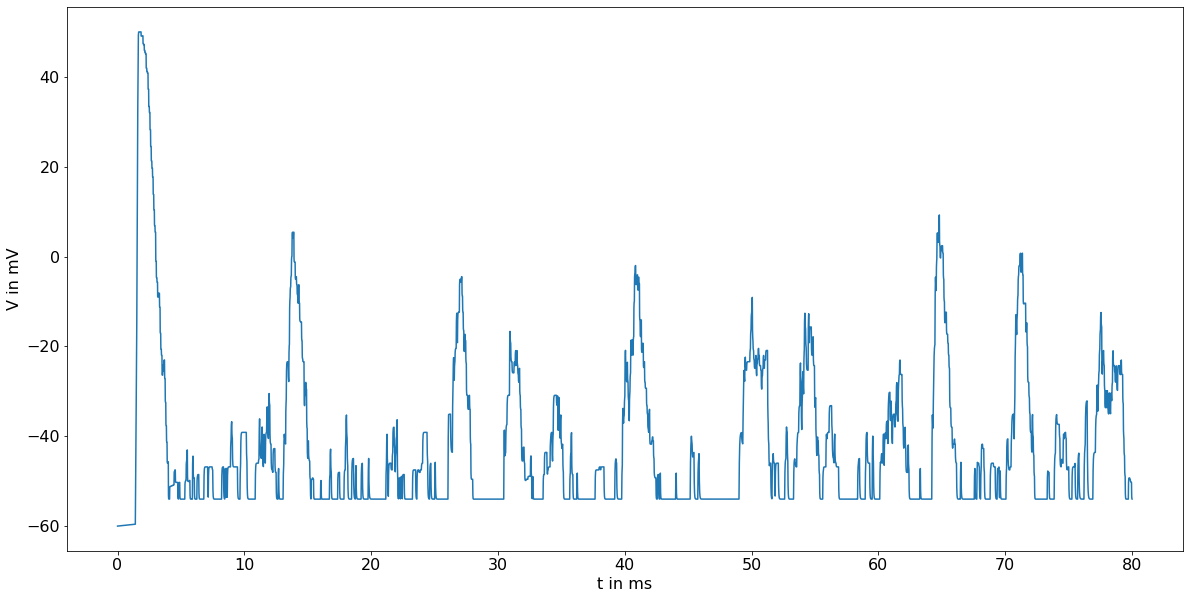

In [20]:
plt.plot(T, V[:-1])
plt.xlabel("t in ms")
plt.ylabel("V in mV")